In [0]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.filters import threshold_otsu
import numpy as np
from glob import glob
import scipy.misc
from matplotlib.patches import Circle,Ellipse
from matplotlib.patches import Rectangle
import os
from PIL import Image

In [2]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


**Load Dataset**

In [3]:
data = glob('./drive/My Drive/FingerPrints/DB*/*')
len(data)

320

**Read Images data**

In [0]:
images = []
def readImages(data):
    for i in range(len(data)):
        img = cv2.imread(data[i])
        img = cv2.resize(img,(224,224))
        images.append(img)
    return images
images = readImages(data)

**Convert images into float32 type**

In [5]:
print(len(images))
images_arr = np.asarray(images)
images_arr = images_arr.astype('float32')
print(images_arr.shape)
#(320, 224, 224)
#Data Exploration
#print("Dataset (images) shape: {shape}".format(shape=images_arr.shape))

320
(320, 224, 224, 3)


**Checking the images after conversion**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


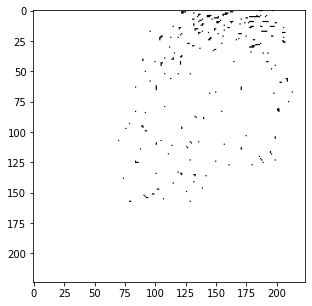

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


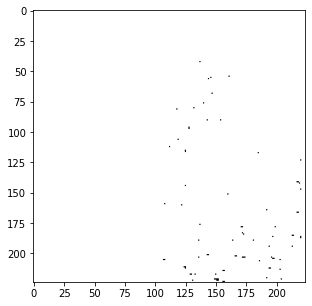

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


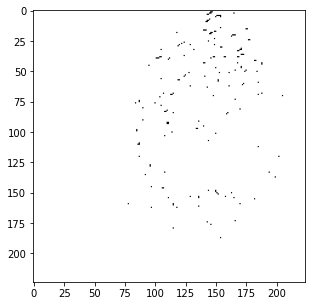

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


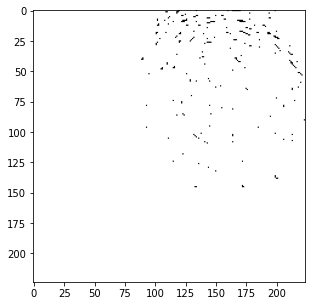

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


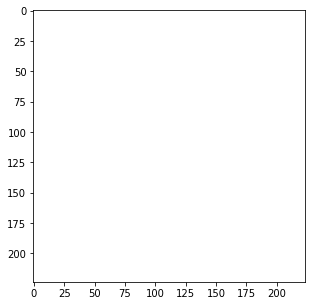

In [6]:
# Display the first image in training data
for i in range(5):
    plt.figure(figsize=[5, 5])
    curr_img = np.reshape(images_arr[i], (224,224,-1))
    #curr_img=np.reshape(images_arr[i], (360,360))
    plt.imshow(curr_img, cmap='gray')
    plt.show()

 **Convert each 224 x 224 image of the dataset into a matrix of size 224 x 224 x 1, which you can then feed into the network.
and rescale the data with the maximum pixel value of the images in the data:**

In [0]:
#You'll first :

images_arr = images_arr.reshape(-1, 224,224, 1)
images_arr.shape
images_arr.dtype
np.max(images_arr)
images_arr = images_arr / np.max(images_arr)

np.max(images_arr), np.min(images_arr)

from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(images_arr,images_arr,test_size=0.2,random_state=13)


**Defie the parameters**

In [0]:
batch_size = 64
epochs = 3
inChannel = 1
x, y = 224, 224
input_img = Input(shape = (x, y, inChannel))

**Define Convolutional Autoencoder**

In [0]:
def autoencoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
    up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [0]:
from keras.models import Model
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [11]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))


Train on 768 samples, validate on 192 samples
Epoch 1/3
768/768 [==============================] - 332s 432ms/step - loss: 0.0656 - val_loss: 0.0662
Epoch 2/3
768/768 [==============================] - 330s 429ms/step - loss: 0.0616 - val_loss: 0.0429
Epoch 3/3
768/768 [==============================] - 327s 426ms/step - loss: 0.0360 - val_loss: 0.0475


**Precticing the result**

In [0]:
pred = autoencoder.predict(valid_X)

**Reconstruction of Test Images**

Test Images


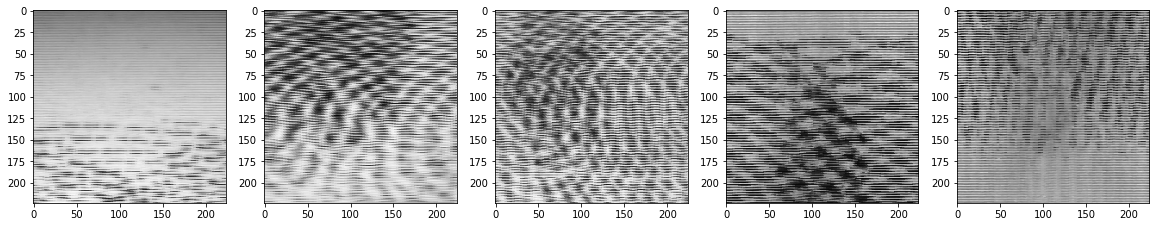

Reconstruction of Test Images


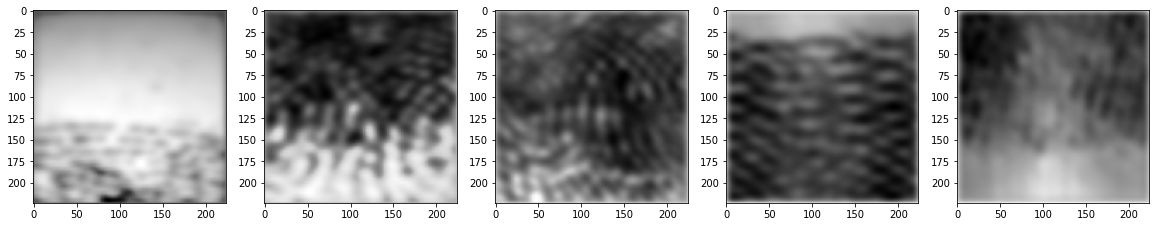

In [14]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(valid_ground[i, ..., 0], cmap='gray')
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()